In [1]:
%load_ext autoreload
%autoreload 2

from importlib import reload
from utils import *
import sys
sys.path.append('/Users/theoares/lqcd/utilities')
import seaborn as sns
import plottools as pt
from scipy.integrate import quad

np.random.seed(10)

## Initialize parameters and Laplace kernel

#### Sparse modeling

This notebook uses principles of sparse modeling to reconstruct a spectral function $\rho(\omega)$ from finite Green's function data $G(\tau)$. $G$ is constructed from the spectral function by a Laplace transform,
$$
    G(\tau) = \int_\mathbb{R} d\omega\, e^{-\omega\tau}\rho(\omega).
$$
This method will discretize the Laplace transform to write it as a matrix equation. The Green's function $G(\tau)$ is evaluated at discrete $\{\tau_i\}$ of size $N_\tau$, and the spectral function is evaluated at discrete $\{\omega_j\}$ of size $N_\omega$, and the discretized vectors are $\mathbf G_i = G(\tau_i)$ and $\mathbf \rho_j = \rho(\omega_j)$. In this form, the previous equation becomes a matrix equation,
$$
    \mathbf{G}_i = K_{ij} \mathbf{\rho}_j,
$$
where $K_{ij} = e^{-\tau_i \omega_j}$ is the discretized Laplace kernel, a matrix of size $N_\tau\times N_\omega$. 

The approach we will take to solving this problem is to exploit the sparsity of $\rho(\omega)$ in a so-called "Intermediate Representation (IR)". An IR is defined by performing a singular value decomposition of $K_{ij}$:
$$
    K = U S V^\dagger,
$$
where $U, V$ are respectively unitary $N_\tau\times N_\tau$ and $N_\omega\times N_\omega$ matrices, and S is the diagonal matrix of singular values. The IR specific to $K$ (as we will have different representations depending on the dimension of $U$ and $V$) is defined as a rotation of $\mathbf G$ and $\mathbf \rho$ by the corresponding unitary matrices $U$ and $V^\dagger$:
\begin{align}
    \mathbf G' = U^\dagger \mathbf G && \mathbf \rho' = V^\dagger \mathbf \rho.
\end{align}
In this representation the components of $\mathbf G'$ and $\mathbf \rho'$ are related by multiplication with a singular value $s_\ell\equiv S_{\ell\ell}$ (note here there is no sum on $\ell$):
$$
    \mathbf G'_\ell = s_\ell \mathbf \rho'_\ell.
$$

In this representation, the spectral function is **sparse**, meaning that it has a large number of components which are zero or very close to 0. We can exploit the sparsity to solve the Least Absolute Shrinkage and Selection Operator (LASSO) problem, which is the optimization problem which corresponds to the minimization of the following function,
$$
    F_{LASSO}(\mathbf x) = \frac{1}{2} ||\mathbf G - K \mathbf x||_2^2 + \lambda ||\mathbf x||_1,
$$
where $||\cdot||_p$ is the $L^p$ norm and $\lambda$ is a \textbf{hyperparameter}, meaning that it is chosen and tweaked by the user to find the best solution to the inverse problem. The $L_1$ norm term is interpreted as a penalty; the optimization searches through the space of $\mathbf x$ and tries to minimize the objective function $|| \mathbf G - K\mathbf x||_2^2$, subject to also trying to minimize $||\mathbf x||_1$. If $\lambda$ is small, minimization of the objective function is most important; however if $\lambda$ is large, minimization of the $L_1$ norm is more important, and so the choise of $\lambda$ is a choice between getting the closest solution to the input data and having a solution which is sparse. 

Note that in our problem, we want to perform the minimization subject to the sparsity of $\mathbf{\rho}'$, the components of $\mathbf \rho$ in an IR. That is, we solve for $\mathbf{\rho}'$ in the following optimization problem:
$$
    \mathbf{\rho'} = \arg\min_\mathbf{\rho'} \left[\frac{1}{2}|| \mathbf{G}' - S \mathbf{\rho}' ||_2^2 + \lambda ||\mathbf{\rho}'||_1\right]
$$
and then rotate back to $\mathbf{\rho} = V \mathbf{\rho}'$ afterward.

#### Enter parameters and save

In [2]:
# parameters
Ntau = 16
Nomega = 64         # 32
omega_max = 2
taus = np.arange(Ntau)

# domain to do reconstruction on (N_ω)
omega_recon = np.linspace(0, omega_max, Nomega)    # domain that rho is simulated on
mesh_spacing = (omega_recon[-1] - omega_recon[0]) / Nomega
omegas = omega_recon                    # to use for recon

# omegas is the linspace that the recon for rho is performed on. It doesn't have to be the same as omega_recon
omega_sim_bounds = [0, omega_max]
domega_sim = 0.01
omega_sim = np.arange(omega_sim_bounds[0], omega_sim_bounds[1], domega_sim)

# Gaussian spectral function
omega0 = 0.8
delOmega = 0.3
def rho(omega):
    return np.exp(- (omega - omega0) ** 2 / (2 * (delOmega ** 2))) / (np.sqrt(2 * np.pi) * delOmega)# * mesh_spacing

# Box rho
# omega_supp = [0.8, 1.1]
# rho = lambda omega : 1 / (omega_supp[1] - omega_supp[0]) if omega > omega_supp[0] and omega < omega_supp[1] else 0

kernel = laplace_kernel(taus, omegas)
kernel_sim = laplace_kernel(taus, omega_sim)
U, svals, Vdag = np.linalg.svd(kernel)
V = hc(Vdag)
S = np.pad(np.diag(svals), [(0, 0), (0, len(omegas) - len(taus))])

rho_sim = np.array([rho(a) * domega_sim for a in omega_sim])
rho_dat = np.array([rho(a) * mesh_spacing for a in omegas])
rhop_dat = Vdag @ rho_dat

# G = kernel @ rho_dat
G = kernel_sim @ rho_sim
print('Evaluating Greens function at tau = it = ' + str(taus))
# print('Sum of ρ_i Δω = ' + str(np.sum(rho_dat) * mesh_spacing))
print('Sum of ρ_i = ' + str(np.sum(rho_dat)))

Evaluating Greens function at tau = it = [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15]
Sum of ρ_i = 0.9811454199778095


In [3]:
# save parameters
test_dir = '/Users/theoares/Dropbox (MIT)/research/spectral/testing/gaussian_'

In [4]:
# SVD sanity checks
print(check_mat_equal(U @ hc(U), np.eye(len(U))))
print(check_mat_equal(V @ Vdag, np.eye(len(Vdag))))
print(check_mat_equal(U @ S @ Vdag, kernel))

(True, 6.661338147750939e-16)
(True, 6.661338147750939e-16)
(True, 1.9984014443252818e-15)


(<Figure size 720x360 with 1 Axes>,
 <AxesSubplot:title={'center':'Singular values $s_\\ell$ of Laplace kernel.'}, xlabel='$\\ell$', ylabel='$\\log(s_\\ell)$'>)

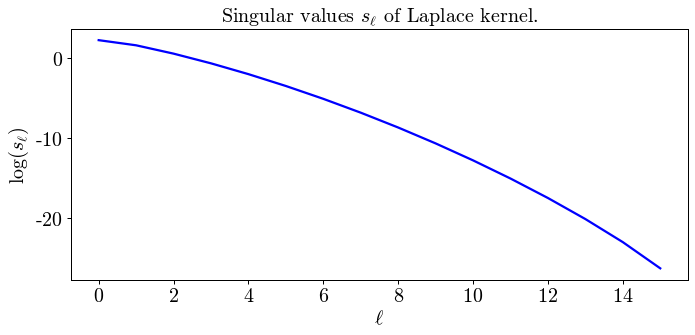

In [36]:
pt.plot_1d_function(np.arange(len(svals)), np.log(svals), ax_label = ['$\ell$', '$\log(s_\ell)$'], \
        title = 'Singular values $s_\ell$ of Laplace kernel.', col = 'b')

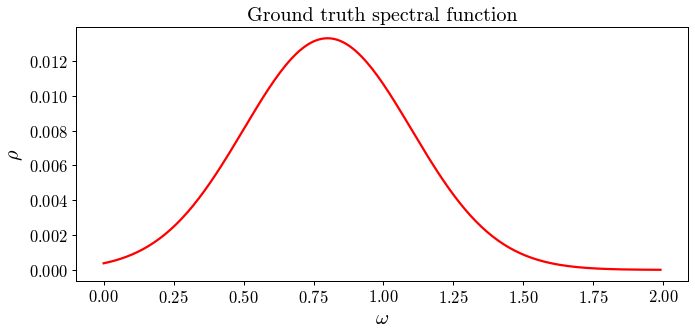

In [8]:
reload(pt)
fig, ax = pt.plot_1d_function(omega_sim, rho_sim, col = 'r', title = 'Ground truth spectral function', ax_label=['$\\omega$',\
            '$\\rho$'], legend = False, saveat_path = '/Users/theoares/Dropbox (MIT)/research/spectral/testing/plot_test.pdf')

(<Figure size 720x360 with 1 Axes>,
 <AxesSubplot:title={'center':'Ground truth spectral function in IR'}, xlabel='$\\omega$', ylabel="$\\rho'$">)

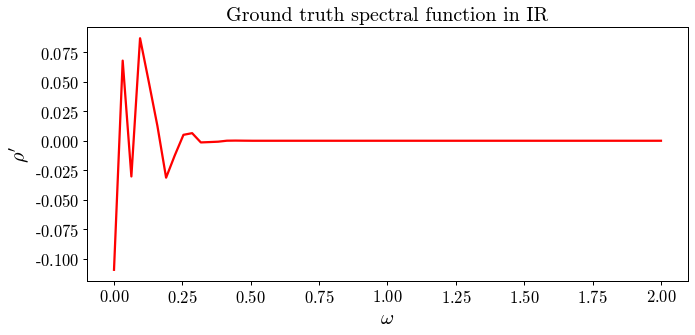

In [9]:
pt.plot_1d_function(omegas, rhop_dat, col = 'r', title = 'Ground truth spectral function in IR', \
                    ax_label = ['$\\omega$', '$\\rho\'$'], legend = False)

(<Figure size 720x360 with 1 Axes>,
 <AxesSubplot:title={'center':"Simulated Green's function (input to algorithm)"}, xlabel='$\\tau$', ylabel='G'>)

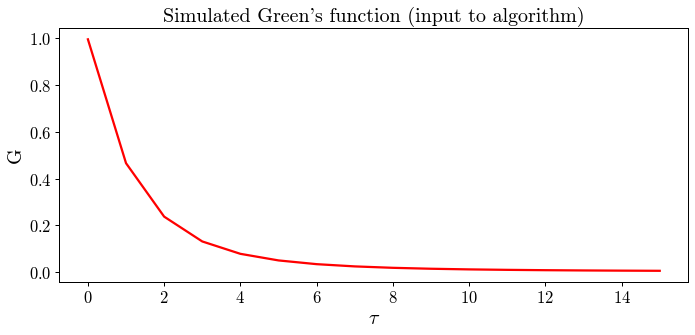

In [10]:
pt.plot_1d_function(taus, G, col = 'r', title = 'Simulated Green\'s function (input to algorithm)', \
                    ax_label = ['$\\tau$', 'G'], legend = False)

## Solve inverse problem with ADMM

#### ADMM parameters

The Alternating Direction Method of Multipliers (ADMM) is an algorithm which solves the LASSO problem. The idea is to impose constraints by adding terms to the minimization problem. This is performed by adding in auxiliary variables to the optimization problem and minimizing / maximizing them all jointly. The basic setup is a bit more lenient than the optimization problem we already have, in which we want to jointly minimize the following equation:
$$
    f(\mathbf x) + g(\mathbf z)\; \mathrm{s.t.}\; A\mathbf x + B\mathbf z = \mathbf c
$$
Here $g$ is non-differentiable and will be taken to be the regularizing term. In ADMM, we form the (scaled) augmented Lagrangian to incorporate the constraint, which adds it in as a part of the optimization rather than doing a projection onto the space which satisfies the constraint:
$$
    L_\rho(\mathbf x, \mathbf y, \mathbf z) = f(\mathbf x) + g(\mathbf z) + \frac{1}{2}\rho || A\mathbf x + B\mathbf z - \mathbf c||_2^2 + \rho \mathbf y^T (A\mathbf x + B\mathbf z - \mathbf c)
$$
where here $\rho$ is a parameter and $\mathbf y$ is a Lagrange multiplier. Each constraint that one enforces in the optimization will add an extra parameter $\rho'$ and Lagrange multiplier $\mathbf y'$, added to the augmented Lagrangian in the same way. 

The idea is that you solve this Lagrangian with an optimization technique similar to dual ascent (which maximizes a dual problem to find the equivalent solution to the optimization), by iteratively performing the following sequence of maximizations / minimizations on the augmented Lagrangian:
$$
    \mathrm{maximize}_\mathbf{y} \; \mathrm{minimize}_{\mathbf z} \; \mathrm{minimize}_{\mathbf x} \; L_\rho(\mathbf x, \mathbf y, \mathbf z).
$$
The "alternating" part of the name comes from this, because you solve the $\vec x$ minimization first, then the $\vec z$ minimization, and finally maximize $\mathbf y$-- the optimization occurs over alternating directions. From iteratively performing this minimization / maximization, the primal variables $\mathbf x$ and $\mathbf z$ will converge to their optimal values.

#### ADMM updates

The ADMM algorithm proceeds by performing the minimizations and maximizations of the augmented Lagrangian:
- Minimize $\mathbf x$. This can be done by simply differentiating the functional with respect to $\mathbf x$ and setting the derivative to $\mathbf 0$.  
- Minimize $\mathbf z$.
- Maximize $\mathbf y$. 

#### Convergence

TODO edit this

Some terminology: $\vec x$ and $\vec z$ are called the **primal variables**, and $\vec y$ (or the scale version $\vec u = \vec y / \rho$) is called the **dual variable**. You get an additional dual variable for each constract that you impose on the system. There are a few different residuals that you can consider in this problem. The obvious one is the **primal residual**:
$$
    r^k = f(\mathbf x^k) + g(\mathbf z^k)
$$
which measures how close to zero the objective function that you're minimizing is. In our case, the primal residual takes the form:
$$
    r^k = ||\mathbf G'^k - S \mathbf\rho'^k||_2^2 + \lambda ||\mathbf\rho'^k||_1
$$
You can also consider the **dual residual**, which measures how close the constraints are to being satisfied:
$$
    d^k = ||A\mathbf x^k + B\mathbf z^k - \mathbf c||_2^2
$$

#### Application to our problem

TODO edit this section, some things are not written out well

For our problem, we need to split up the optimization into the form $f(\vec \rho') + g(\vec z')$, and we have two constraints: non-negativity and the sum rule. We need to add in a bunch of auxiliary variables consistent with the previous cell to deal with these. The variables which are added in are:
- $\vec z'$, which converges to $\rho'$. This is added to give the optimization problem the correct form. The additional constraint to enforce is:
$$
    \vec z' = \vec \rho'
$$
- $\vec z$, which converges to the original $\vec\rho$. The additional constraint to enforce is:
$$
    \vec z = V \vec\rho'
$$
To enforce these constraints, additional hyperparameters $\mu$ and $\mu'$ are added in, as well as scaled Lagrange multipliers $\vec u$ and $\vec u'$. 
- $\mu$ and $\vec u$: These enforce the constraint $\vec z = V\vec \rho'$. This is added to the augmented Lagrangian (the function to min / max over) as:
$$
    \frac{1}{2}\mu ||\vec z - V\vec \rho' ||_2^2 + \vec u^T (\vec z - V\vec\rho')
$$
- $\mu'$ and $\vec u'$: These enforce the constraint $\vec z' = \vec \rho'$, and $\mu'$ controls the speed of convergence (not sure why at the moment). The following term is added to the augmented Lagrangian:
$$
    \frac{1}{2} \mu' ||\vec z' - \vec\rho' ||_2^2 + \vec u'^T (\vec z - \vec \rho')
$$

In [11]:
# initialize parameters. Here we'll use the default settings.
params = ADMMParams.default_params(Nomega, d = (Ntau, Nomega))
params.lam = 1e-5
params.mu = 1e-5
params.mup = 1e-5
# params.lam = 1e-4
# params.mu = 1.
# params.mup = 1e-4
params.max_iters = 10000
params.eps = 1e-5

In [12]:
rho_recon, xp, primal_resid, dual_resid, iters = \
            admm(G, taus, omegas, params, disp_iters = 1000)
#            admm(G, taus, omegas, params, resid_norm = lpnorm(1), disp_iters = 1000)

Starting solver.
Iteration 1000: primal residual = 0.0036772199199832205, dual resid = 0.004998426745919888, elapsed time = 0.13000702857971191
Iteration 2000: primal residual = 0.003677223245054574, dual resid = 0.004155972184918455, elapsed time = 0.2377159595489502
Iteration 3000: primal residual = 0.0036772277044563595, dual resid = 0.003667010516519111, elapsed time = 0.35767698287963867
Iteration 4000: primal residual = 0.0036772332364475063, dual resid = 0.0032283965468253273, elapsed time = 0.4650890827178955
Iteration 5000: primal residual = 0.003677239530850922, dual resid = 0.0028755578339023273, elapsed time = 0.585637092590332
Iteration 6000: primal residual = 0.0036772463551642, dual resid = 0.0024827681584838023, elapsed time = 0.6953821182250977
Iteration 7000: primal residual = 0.0036772535511030054, dual resid = 0.0022081095383032325, elapsed time = 0.8041479587554932
Iteration 8000: primal residual = 0.0036772609851988556, dual resid = 0.001965637140381532, elapsed t

(-0.0021192065052067603, 0.04450333660934197)


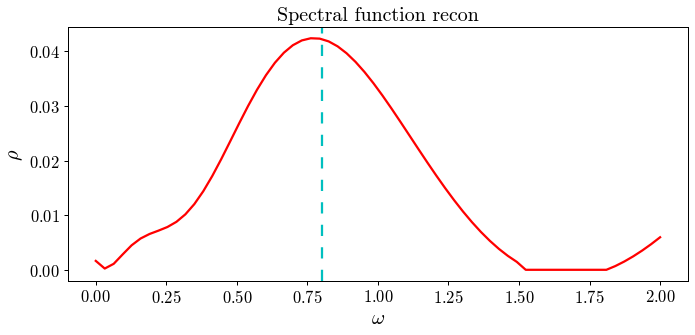

In [13]:
# currently normalized so that sum_i rho_i = 1, but we want sum_i Delta\omega = 1
with sns.plotting_context('talk'):
    fig, ax = plt.subplots(1, figsize = (10, 5))
    pt.plot_1d_function(omegas, rho_recon, ax = ax, col = 'r', title = 'Spectral function recon', \
                     ax_label = ['$\\omega$', '$\\rho$'], legend = False)
    print(ax.get_ylim())
    pt.add_line(ax, omega0, color = 'c', dashes = (5, 5), label = '$\\omega_0$')

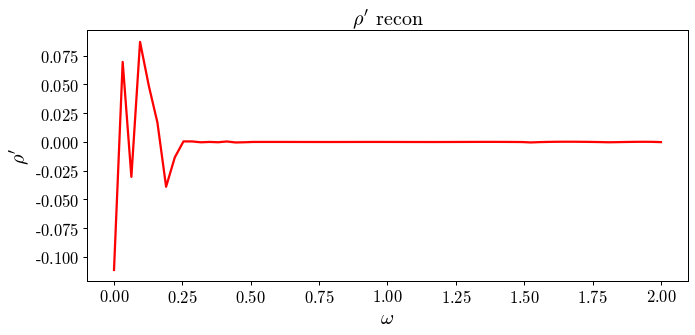

In [15]:
# looks close to the original
with sns.plotting_context('talk'):
    fig, ax = plt.subplots(1, figsize = (10, 5))
    pt.plot_1d_function(omegas, xp, ax = ax, col = 'r', title = r'$\rho^\prime$ recon', \
                     ax_label = [r'$\omega$', r'$\rho^\prime$'], legend = False)

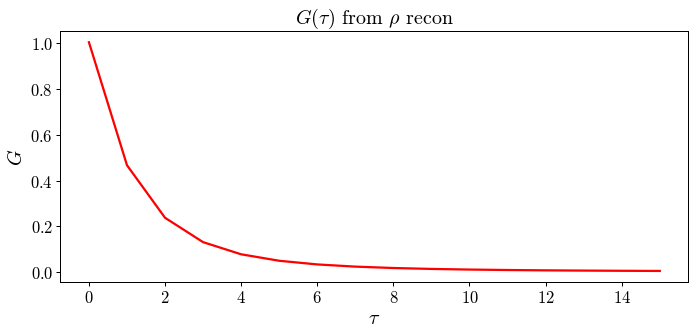

In [19]:
# looks close to the original, but the scale is absolutely off
Grecon = kernel @ rho_recon
with sns.plotting_context('talk'):
    fig, ax = plt.subplots(1, figsize = (10, 5))
    pt.plot_1d_function(taus, Grecon, ax = ax, col = 'r', title = r'$G(\tau)$ from $\rho$ recon', \
                     ax_label = [r'$\tau$', '$G$'], legend = False)

#### Scan the parameter range

The hyperparameters $(\lambda, \mu, \mu')$ are inputs to the optimization problem and can be tuned. As a result, the reconstruction $\mathbf \rho$ depends on each of these input parameters, i.e. $\mathbf \rho = \mathbf\rho(\lambda, \mu, \mu')$, and changing each hyperparameter may change the general structure of the reconstruction. As a rule of thumb, the range of possible hyperparameters should be scanned over to see what yields the "best" reconstruction. Once this is properly tested and worked with, this part could be done in parallel, since we're just performing the same computation and looping over the input parameters.  

Defining "best" requires some work, especially when we're doing this in practice (and not in simulation) and don't know what the ground truth $\mathbf \rho$ should look like. The easiest way to do this is to define a fidelity function Fid:
$$
    \mathrm{Fid} : \{\mathbf \rho(\lambda, \mu, \mu')\}\rightarrow \mathbb{R}
$$
which tells us how "good" the reconstruction is. The better the reconstruction, the closer the fidelity metric is to 0, so at the end of the day we can find the best hyperparameters by minimizing Fid:
$$
    (\lambda^*, \mu^*, \mu'^*) = \arg\min_{\lambda, \mu, \mu'} \mathrm{Fid}(\mathbf\rho(\lambda, \mu, \mu'))
$$

The fidelity function I'm currently using is simply the distance between the output Green's function from $\mathbf \rho$ and the actual measured Green's function:
$$
    \mathrm{Fid}(\mathbf \rho) = ||\mathbf G - K\mathbf \rho ||_2^2
$$
but this does not always give the best result, simply because the problem is underdetermined (it's also strangely close for a lot of the reconds, so I think there's something up). 

Some extra terms I'd like to add to the fidelity function: 
- Use input from correlator fits to specify that there should be a "peak" in the spectral function around its ground state at $\omega_0$, and no peak before that. I need to design a specific functional form for that as well, and I'd like to add that as a constraint in the actual algorithm too. 
- Some form of smoothness prior to prevent rapid oscillations. 

In [20]:
# lam_list = [10 ** n for n in np.arange(-8, 1., 2.)]
lam_list = [10 ** n for n in np.arange(-5, 1., 1.)]
mu_list = lam_list
mup_list = lam_list
max_iters = 10000
# max_iters = 50000
rho_recons, p_resids, d_resids = parameter_scan(G, taus, omegas, lam_list, mu_list, mup_list, max_iters)

(lambda, mu, mup) = (1e-05, 1e-05, 1e-05)
Starting solver.
Iteration 1000: primal residual = 0.0036772199199832205, dual resid = 0.004998426745919888, elapsed time = 0.16767001152038574
Iteration 2000: primal residual = 0.003677223245054574, dual resid = 0.004155972184918455, elapsed time = 0.33455896377563477
Iteration 3000: primal residual = 0.0036772277044563595, dual resid = 0.003667010516519111, elapsed time = 0.4992680549621582
Iteration 4000: primal residual = 0.0036772332364475063, dual resid = 0.0032283965468253273, elapsed time = 0.6427807807922363
Iteration 5000: primal residual = 0.003677239530850922, dual resid = 0.0028755578339023273, elapsed time = 0.7808911800384521
Iteration 6000: primal residual = 0.0036772463551642, dual resid = 0.0024827681584838023, elapsed time = 0.9168691635131836
Iteration 7000: primal residual = 0.0036772535511030054, dual resid = 0.0022081095383032325, elapsed time = 1.0839219093322754
Iteration 8000: primal residual = 0.0036772609851988556, d

Iteration 8000: primal residual = 0.0037004114286289668, dual resid = 0.01354247864038967, elapsed time = 1.0702879428863525
Iteration 9000: primal residual = 0.0037004102238649616, dual resid = 0.01354230008960393, elapsed time = 1.1994259357452393
Iteration 10000: primal residual = 0.0037004090191943093, dual resid = 0.01354212154425542, elapsed time = 1.3269970417022705
Run complete. 
   Iterations: 10000
   Primal residual: 0.0037004090191943093
   Dual residual: 0.01354212154425542
   Elapsed time: 1.3270740509033203
(lambda, mu, mup) = (1e-05, 0.0001, 1e-05)
Starting solver.
Iteration 1000: primal residual = 0.0036772213931760144, dual resid = 0.0014575713548121527, elapsed time = 0.15093111991882324
Iteration 2000: primal residual = 0.003677225237449966, dual resid = 0.0011135776462409257, elapsed time = 0.2777061462402344
Iteration 3000: primal residual = 0.0036772304282949517, dual resid = 0.0009213649085328746, elapsed time = 0.42658209800720215
Iteration 4000: primal residua

Iteration 4000: primal residual = 0.0037003729458154515, dual resid = 0.013536336125644028, elapsed time = 0.5146701335906982
Iteration 5000: primal residual = 0.00370036093253472, dual resid = 0.013534552682712309, elapsed time = 0.6531200408935547
Iteration 6000: primal residual = 0.0037003489286030217, dual resid = 0.013532769782915474, elapsed time = 0.7841711044311523
Iteration 7000: primal residual = 0.0037003369340156797, dual resid = 0.013530987426117722, elapsed time = 0.9224419593811035
Iteration 8000: primal residual = 0.0037003249487680234, dual resid = 0.013529205612182606, elapsed time = 1.0514130592346191
Iteration 9000: primal residual = 0.0037003129728551644, dual resid = 0.013527424340975041, elapsed time = 1.1912672519683838
Iteration 10000: primal residual = 0.003700301006271922, dual resid = 0.013525643612358479, elapsed time = 1.3192009925842285
Run complete. 
   Iterations: 10000
   Primal residual: 0.003700301006271922
   Dual residual: 0.013525643612358479
   E

Iteration 2000: primal residual = 0.0037001821154562164, dual resid = 0.013503566072372459, elapsed time = 0.2599022388458252
Iteration 3000: primal residual = 0.003700063907901457, dual resid = 0.013485850760079498, elapsed time = 0.39151811599731445
Iteration 4000: primal residual = 0.0036999466228595504, dual resid = 0.013468189390072468, elapsed time = 0.551353931427002
Iteration 5000: primal residual = 0.0036998302555747197, dual resid = 0.013450581827096075, elapsed time = 0.6951520442962646
Iteration 6000: primal residual = 0.003699714801312676, dual resid = 0.013433027936107365, elapsed time = 0.8251070976257324
Iteration 7000: primal residual = 0.003699600255360636, dual resid = 0.013415527582275892, elapsed time = 0.9714689254760742
Iteration 8000: primal residual = 0.0036994866130285963, dual resid = 0.013398080630981017, elapsed time = 1.100618839263916
Iteration 9000: primal residual = 0.0036993738696488444, dual resid = 0.013380686947812621, elapsed time = 1.2371199131011

Iteration 5000: primal residual = 0.003695478064767166, dual resid = 0.01267256205468367, elapsed time = 0.6041369438171387
Iteration 6000: primal residual = 0.0036947205058564282, dual resid = 0.012522444355447812, elapsed time = 0.7329051494598389
Iteration 7000: primal residual = 0.0036940307733280527, dual resid = 0.012376841172217032, elapsed time = 0.8626570701599121
Iteration 8000: primal residual = 0.003693405655737287, dual resid = 0.012235675604401398, elapsed time = 1.0245282649993896
Iteration 9000: primal residual = 0.003692841822538808, dual resid = 0.012098831577256493, elapsed time = 1.148982048034668
Iteration 10000: primal residual = 0.0036923360981948464, dual resid = 0.011966194904870338, elapsed time = 1.2745981216430664
Run complete. 
   Iterations: 10000
   Primal residual: 0.0036923360981948464
   Dual residual: 0.011966194904870338
   Elapsed time: 1.2747740745544434
(lambda, mu, mup) = (1e-05, 0.1, 1e-05)
Starting solver.
Run complete. 
   Iterations: 25
   Pr

Iteration 5000: primal residual = 0.0036840383517826383, dual resid = 0.00046144272301647325, elapsed time = 0.7046029567718506
Iteration 6000: primal residual = 0.0036837427220437063, dual resid = 0.0001691278236940291, elapsed time = 0.8422329425811768
Iteration 7000: primal residual = 0.0036835364377016564, dual resid = 0.00016325005891188067, elapsed time = 0.969696044921875
Iteration 8000: primal residual = 0.0036831124981521212, dual resid = 0.0001477668582976287, elapsed time = 1.1338660717010498
Iteration 9000: primal residual = 0.003682904971522644, dual resid = 0.00012255632201926302, elapsed time = 1.299009084701538
Iteration 10000: primal residual = 0.003682794445397117, dual resid = 0.00010249959756145826, elapsed time = 1.4531898498535156
Run complete. 
   Iterations: 10000
   Primal residual: 0.003682794445397117
   Dual residual: 0.00010249959756145826
   Elapsed time: 1.4533257484436035
(lambda, mu, mup) = (1e-05, 1.0, 0.1)
Starting solver.
Iteration 1000: primal resid

Iteration 1000: primal residual = 0.003721057245903183, dual resid = 0.012916260991801112, elapsed time = 0.16168498992919922
Iteration 2000: primal residual = 0.0037796336169145304, dual resid = 0.013523186063625457, elapsed time = 0.30361080169677734
Iteration 3000: primal residual = 0.0037943132552733733, dual resid = 0.013975348043507228, elapsed time = 0.46448373794555664
Iteration 4000: primal residual = 0.003796569259494589, dual resid = 0.014099115699831539, elapsed time = 0.6109788417816162
Iteration 5000: primal residual = 0.0037974004963774225, dual resid = 0.014170907079868575, elapsed time = 0.7670447826385498
Iteration 6000: primal residual = 0.0037977117545743818, dual resid = 0.014197104189378786, elapsed time = 0.907829999923706
Iteration 7000: primal residual = 0.0037978308160042107, dual resid = 0.014206619257272889, elapsed time = 1.0616788864135742
Iteration 8000: primal residual = 0.003797879300697013, dual resid = 0.01421003108485159, elapsed time = 1.19248580932

Iteration 9000: primal residual = 0.0037151107519662455, dual resid = 0.012239186796335169, elapsed time = 1.2361259460449219
Iteration 10000: primal residual = 0.0037205202929664633, dual resid = 0.012358209081963613, elapsed time = 1.4281222820281982
Run complete. 
   Iterations: 10000
   Primal residual: 0.0037205202929664633
   Dual residual: 0.012358209081963613
   Elapsed time: 1.428220272064209
(lambda, mu, mup) = (0.0001, 0.0001, 0.01)
Starting solver.
Iteration 1000: primal residual = 0.0037210046140033295, dual resid = 0.01286269422258211, elapsed time = 0.16615724563598633
Iteration 2000: primal residual = 0.003779583413149975, dual resid = 0.013461219381449986, elapsed time = 0.31552934646606445
Iteration 3000: primal residual = 0.003794291093378385, dual resid = 0.013908272596412936, elapsed time = 0.4588470458984375
Iteration 4000: primal residual = 0.0037965942016931664, dual resid = 0.0140292734648887, elapsed time = 0.6244044303894043
Iteration 5000: primal residual = 

Iteration 4000: primal residual = 0.003691448748001687, dual resid = 0.008634600045417887, elapsed time = 0.5953211784362793
Iteration 5000: primal residual = 0.003694761925515903, dual resid = 0.008750499249603564, elapsed time = 0.7463350296020508
Iteration 6000: primal residual = 0.003698549397645923, dual resid = 0.00885270637949202, elapsed time = 0.8792500495910645
Iteration 7000: primal residual = 0.0037027622618040585, dual resid = 0.008940929052621395, elapsed time = 1.0013401508331299
Iteration 8000: primal residual = 0.003707364032183712, dual resid = 0.009015344300448973, elapsed time = 1.1251871585845947
Iteration 9000: primal residual = 0.0037123275086073915, dual resid = 0.009076516015095569, elapsed time = 1.2647171020507812
Iteration 10000: primal residual = 0.0037176214528916065, dual resid = 0.00912590823405758, elapsed time = 1.4034500122070312
Run complete. 
   Iterations: 10000
   Primal residual: 0.0037176214528916065
   Dual residual: 0.00912590823405758
   Elap

Iteration 1000: primal residual = 0.003717614436720857, dual resid = 0.00912525614612852, elapsed time = 0.13144493103027344
Iteration 2000: primal residual = 0.003777837598172856, dual resid = 0.00919296225439649, elapsed time = 0.26414966583251953
Iteration 3000: primal residual = 0.0037960081647361596, dual resid = 0.009329954574290212, elapsed time = 0.3845558166503906
Iteration 4000: primal residual = 0.003802380585810176, dual resid = 0.00928193993105636, elapsed time = 0.5105159282684326
Iteration 5000: primal residual = 0.0038092996853618995, dual resid = 0.009291586680657219, elapsed time = 0.6410417556762695
Iteration 6000: primal residual = 0.003815857603505559, dual resid = 0.009259447619449895, elapsed time = 0.7797110080718994
Iteration 7000: primal residual = 0.003822382145246581, dual resid = 0.0092117334634395, elapsed time = 0.9444057941436768
Iteration 8000: primal residual = 0.0038289820540848983, dual resid = 0.009159255552969545, elapsed time = 1.1095187664031982


Iteration 5000: primal residual = 0.003976415033264796, dual resid = 0.0011130606953564594, elapsed time = 0.6804029941558838
Iteration 6000: primal residual = 0.003972917671058401, dual resid = 0.0007545250405012904, elapsed time = 0.8083641529083252
Iteration 7000: primal residual = 0.003969676788428439, dual resid = 0.0007273885087074085, elapsed time = 0.9349761009216309
Iteration 8000: primal residual = 0.003966647246825602, dual resid = 0.0007013529118455915, elapsed time = 1.0722413063049316
Iteration 9000: primal residual = 0.003963814558695663, dual resid = 0.0006763781711436924, elapsed time = 1.1997370719909668
Iteration 10000: primal residual = 0.003962291179454222, dual resid = 0.0004305788624965035, elapsed time = 1.3423421382904053
Run complete. 
   Iterations: 10000
   Primal residual: 0.003962291179454222
   Dual residual: 0.0004305788624965035
   Elapsed time: 1.342480182647705
(lambda, mu, mup) = (0.0001, 0.1, 1.0)
Starting solver.
Iteration 1000: primal residual = 0

Iteration 7000: primal residual = 0.0037051961333963664, dual resid = 0.011948431618719228, elapsed time = 0.9224612712860107
Iteration 8000: primal residual = 0.0037099899275149697, dual resid = 0.012103163885851373, elapsed time = 1.072192907333374
Iteration 9000: primal residual = 0.0037151108860071515, dual resid = 0.012239152520340317, elapsed time = 1.230140209197998
Iteration 10000: primal residual = 0.003720530798578799, dual resid = 0.012357258486223202, elapsed time = 1.3524081707000732
Run complete. 
   Iterations: 10000
   Primal residual: 0.003720530798578799
   Dual residual: 0.012357258486223202
   Elapsed time: 1.3525390625
(lambda, mu, mup) = (0.001, 1e-05, 0.001)
Starting solver.
Iteration 1000: primal residual = 0.0037210149623754366, dual resid = 0.012861722664178695, elapsed time = 0.14305591583251953
Iteration 2000: primal residual = 0.003788808330100479, dual resid = 0.013372114532980355, elapsed time = 0.2822530269622803
Iteration 3000: primal residual = 0.00387

Iteration 3000: primal residual = 0.003688673261626216, dual resid = 0.008504342926085295, elapsed time = 0.4520120620727539
Iteration 4000: primal residual = 0.0036914487480016883, dual resid = 0.008634600045417634, elapsed time = 0.6022319793701172
Iteration 5000: primal residual = 0.0036947619255159585, dual resid = 0.008750499249602996, elapsed time = 0.7291867733001709
Iteration 6000: primal residual = 0.0036985493976458925, dual resid = 0.008852706379491558, elapsed time = 0.8913710117340088
Iteration 7000: primal residual = 0.0037027622618039024, dual resid = 0.008940929052622172, elapsed time = 1.0580947399139404
Iteration 8000: primal residual = 0.0037073640321837096, dual resid = 0.009015344300448985, elapsed time = 1.1878178119659424
Iteration 9000: primal residual = 0.0037123276588035656, dual resid = 0.0090764862753964, elapsed time = 1.305776834487915
Iteration 10000: primal residual = 0.0037176331488620986, dual resid = 0.00912510823362505, elapsed time = 1.4351568222045

Iteration 1000: primal residual = 0.0036819866462670793, dual resid = 0.0029634292414890623, elapsed time = 0.15362882614135742
Iteration 2000: primal residual = 0.003683353821604485, dual resid = 0.0030290405028253757, elapsed time = 0.2779419422149658
Iteration 3000: primal residual = 0.0036853713385099816, dual resid = 0.003032459708366066, elapsed time = 0.4268789291381836
Iteration 4000: primal residual = 0.0036880428428071586, dual resid = 0.0030307877401158367, elapsed time = 0.5759067535400391
Iteration 5000: primal residual = 0.0036913223903441475, dual resid = 0.0030240068731352595, elapsed time = 0.711378812789917
Iteration 6000: primal residual = 0.0036951773987871457, dual resid = 0.0030122703848868486, elapsed time = 0.8401238918304443
Iteration 7000: primal residual = 0.003699583767377663, dual resid = 0.0029960259603977984, elapsed time = 0.9913249015808105
Iteration 8000: primal residual = 0.003704522448037635, dual resid = 0.0029758481951790722, elapsed time = 1.15551

Iteration 7000: primal residual = 0.0037000296039329268, dual resid = 0.00041933865902632174, elapsed time = 0.870507001876831
Iteration 8000: primal residual = 0.003705679545810706, dual resid = 0.0004111830727981519, elapsed time = 1.0361089706420898
Iteration 9000: primal residual = 0.0037119437440000444, dual resid = 0.00040287042318472527, elapsed time = 1.197693109512329
Iteration 10000: primal residual = 0.0037187958587921017, dual resid = 0.00039450076360391826, elapsed time = 1.3621699810028076
Run complete. 
   Iterations: 10000
   Primal residual: 0.0037187958587921017
   Dual residual: 0.00039450076360391826
   Elapsed time: 1.3622629642486572
(lambda, mu, mup) = (0.001, 0.01, 0.001)
Starting solver.
Iteration 1000: primal residual = 0.003715928685886227, dual resid = 0.0029259943340720494, elapsed time = 0.16549301147460938
Iteration 2000: primal residual = 0.003800094678831757, dual resid = 0.0026024953022777296, elapsed time = 0.3302788734436035
Iteration 3000: primal re

Iteration 10000: primal residual = 0.0060300631316291, dual resid = 0.0010033339266027987, elapsed time = 1.4466497898101807
Run complete. 
   Iterations: 10000
   Primal residual: 0.0060300631316291
   Dual residual: 0.0010033339266027987
   Elapsed time: 1.4467220306396484
(lambda, mu, mup) = (0.001, 0.1, 0.1)
Starting solver.
Iteration 1000: primal residual = 0.006721728581401899, dual resid = 0.007484010996292248, elapsed time = 0.12981367111206055
Iteration 2000: primal residual = 0.006117147359162024, dual resid = 0.004643899341930883, elapsed time = 0.25714588165283203
Iteration 3000: primal residual = 0.006141101658596631, dual resid = 0.00413140557086354, elapsed time = 0.39041686058044434
Iteration 4000: primal residual = 0.006300116600443386, dual resid = 0.003912022191532639, elapsed time = 0.5155847072601318
Iteration 5000: primal residual = 0.006434130403376747, dual resid = 0.0018839688054128189, elapsed time = 0.6755588054656982
Iteration 6000: primal residual = 0.00653

Iteration 2000: primal residual = 0.003686484239652791, dual resid = 0.008327070264509776, elapsed time = 0.24573397636413574
Iteration 3000: primal residual = 0.003688673261626207, dual resid = 0.008504342926085106, elapsed time = 0.3809621334075928
Iteration 4000: primal residual = 0.0036914487480016168, dual resid = 0.008634600045418024, elapsed time = 0.5174779891967773
Iteration 5000: primal residual = 0.0036947619255159997, dual resid = 0.008750499249602512, elapsed time = 0.6550700664520264
Iteration 6000: primal residual = 0.003698549397645891, dual resid = 0.008852706379491588, elapsed time = 0.7899479866027832
Iteration 7000: primal residual = 0.00370276226180393, dual resid = 0.008940929052622226, elapsed time = 0.9452099800109863
Iteration 8000: primal residual = 0.0037073640321836653, dual resid = 0.00901534430044921, elapsed time = 1.117602825164795
Iteration 9000: primal residual = 0.0037123276588033522, dual resid = 0.009076486275396365, elapsed time = 1.251708984375
It

Iteration 1000: primal residual = 0.003681986646267009, dual resid = 0.0029634292414890966, elapsed time = 0.16919469833374023
Iteration 2000: primal residual = 0.0036833538216045993, dual resid = 0.0030290405028253068, elapsed time = 0.3168158531188965
Iteration 3000: primal residual = 0.0036853713385097122, dual resid = 0.003032459708366524, elapsed time = 0.44505977630615234
Iteration 4000: primal residual = 0.0036880428428072, dual resid = 0.003030787740115796, elapsed time = 0.5628550052642822
Iteration 5000: primal residual = 0.003691322390344148, dual resid = 0.003024006873135711, elapsed time = 0.6844408512115479
Iteration 6000: primal residual = 0.003695177398787108, dual resid = 0.0030122703848864895, elapsed time = 0.8412580490112305
Iteration 7000: primal residual = 0.0036995837673774496, dual resid = 0.002996025960398366, elapsed time = 1.0057287216186523
Iteration 8000: primal residual = 0.0037045224480377636, dual resid = 0.0029758481951793823, elapsed time = 1.130007982

Iteration 9000: primal residual = 0.020923590995431087, dual resid = 0.005257444718671387, elapsed time = 1.3088409900665283
Iteration 10000: primal residual = 0.02092567619117538, dual resid = 0.005256413074435488, elapsed time = 1.4510529041290283
Run complete. 
   Iterations: 10000
   Primal residual: 0.02092567619117538
   Dual residual: 0.005256413074435488
   Elapsed time: 1.4511909484863281
(lambda, mu, mup) = (0.01, 0.001, 1e-05)
Starting solver.
Iteration 1000: primal residual = 0.003680615108080268, dual resid = 0.00045445618533547754, elapsed time = 0.11777091026306152
Iteration 2000: primal residual = 0.003681964001214608, dual resid = 0.0004516624477355999, elapsed time = 0.23293685913085938
Iteration 3000: primal residual = 0.003684119019583029, dual resid = 0.00044711617450928995, elapsed time = 0.36498188972473145
Iteration 4000: primal residual = 0.0036870360369152242, dual resid = 0.0004413346839904938, elapsed time = 0.4860570430755615
Iteration 5000: primal residual

Iteration 5000: primal residual = 0.0210085463981337, dual resid = 0.005213014152296471, elapsed time = 0.6769740581512451
Iteration 6000: primal residual = 0.02102909428057254, dual resid = 0.005202933238147155, elapsed time = 0.7945640087127686
Iteration 7000: primal residual = 0.021049577943971578, dual resid = 0.005192901446636316, elapsed time = 0.9129321575164795
Iteration 8000: primal residual = 0.02106999756610206, dual resid = 0.0051829185775095375, elapsed time = 1.039534091949463
Iteration 9000: primal residual = 0.021090353324681965, dual resid = 0.005172984431013097, elapsed time = 1.1620972156524658
Iteration 10000: primal residual = 0.021110645397368313, dual resid = 0.005163098807893152, elapsed time = 1.2939109802246094
Run complete. 
   Iterations: 10000
   Primal residual: 0.021110645397368313
   Dual residual: 0.005163098807893152
   Elapsed time: 1.293992280960083
(lambda, mu, mup) = (0.01, 0.01, 1e-05)
Starting solver.
Run complete. 
   Iterations: 18
   Primal re

Iteration 6000: primal residual = 0.011653156823583206, dual resid = 0.00020953762598528453, elapsed time = 0.9223380088806152
Iteration 7000: primal residual = 0.012927737849070945, dual resid = 0.00017917275514271866, elapsed time = 1.0414397716522217
Iteration 8000: primal residual = 0.014163339913858262, dual resid = 0.0001514312279134161, elapsed time = 1.1642301082611084
Iteration 9000: primal residual = 0.015356695327299908, dual resid = 0.00013749997147956885, elapsed time = 1.2925488948822021
Iteration 10000: primal residual = 0.01649779140845312, dual resid = 0.00011622343042043715, elapsed time = 1.416862964630127
Run complete. 
   Iterations: 10000
   Primal residual: 0.01649779140845312
   Dual residual: 0.00011622343042043715
   Elapsed time: 1.4169409275054932
(lambda, mu, mup) = (0.01, 0.1, 0.01)
Starting solver.
Iteration 1000: primal residual = 0.016334095464222428, dual resid = 0.0010612029469684074, elapsed time = 0.1316089630126953
Iteration 2000: primal residual =

Iteration 1000: primal residual = 0.02374231222289103, dual resid = 0.0006254974694515166, elapsed time = 0.12319588661193848
Iteration 2000: primal residual = 0.025137597567633122, dual resid = 0.0006453840588492064, elapsed time = 0.24190402030944824
Iteration 3000: primal residual = 0.026016432642630732, dual resid = 0.0005699863537191337, elapsed time = 0.36310720443725586
Iteration 4000: primal residual = 0.026768989218921093, dual resid = 0.000501105364724445, elapsed time = 0.5186140537261963
Iteration 5000: primal residual = 0.02725739998673596, dual resid = 0.0002580542582223871, elapsed time = 0.6462969779968262
Iteration 6000: primal residual = 0.026739934014582082, dual resid = 0.00017392819656243514, elapsed time = 0.7622580528259277
Iteration 7000: primal residual = 0.02660260676993437, dual resid = 0.0002212081691200613, elapsed time = 0.8834750652313232
Iteration 8000: primal residual = 0.026751143830632613, dual resid = 8.733700026159392e-05, elapsed time = 1.006057977

Iteration 1000: primal residual = 0.07493148773558306, dual resid = 0.0026657154710844557, elapsed time = 0.1370398998260498
Iteration 2000: primal residual = 0.07655640303328987, dual resid = 0.0021490280340261832, elapsed time = 0.28162193298339844
Iteration 3000: primal residual = 0.07655684255313532, dual resid = 0.002148873285235138, elapsed time = 0.4332869052886963
Iteration 4000: primal residual = 0.0765572820431493, dual resid = 0.0021487185475841932, elapsed time = 0.5949859619140625
Iteration 5000: primal residual = 0.0765577215033363, dual resid = 0.0021485638210757057, elapsed time = 0.7571799755096436
Iteration 6000: primal residual = 0.07655816093369819, dual resid = 0.002148409105708897, elapsed time = 0.896662712097168
Iteration 7000: primal residual = 0.07655860033423684, dual resid = 0.002148254401482957, elapsed time = 1.0512967109680176
Iteration 8000: primal residual = 0.07655903970495409, dual resid = 0.002148099708397047, elapsed time = 1.1867468357086182
Iterat

Iteration 9000: primal residual = 0.07417902463860246, dual resid = 0.0028927967042919477, elapsed time = 1.213994026184082
Iteration 10000: primal residual = 0.07497017404282355, dual resid = 0.0026373112520341278, elapsed time = 1.3345470428466797
Run complete. 
   Iterations: 10000
   Primal residual: 0.07497017404282355
   Dual residual: 0.0026373112520341278
   Elapsed time: 1.334686040878296
(lambda, mu, mup) = (0.1, 0.0001, 0.1)
Starting solver.
Iteration 1000: primal residual = 0.07493418798734489, dual resid = 0.0026633836676270904, elapsed time = 0.1229400634765625
Iteration 2000: primal residual = 0.07657063032789188, dual resid = 0.0021430870286999375, elapsed time = 0.24184012413024902
Iteration 3000: primal residual = 0.07657501282156734, dual resid = 0.002141544928465589, elapsed time = 0.36391401290893555
Iteration 4000: primal residual = 0.0765793923423269, dual resid = 0.0021400039378761068, elapsed time = 0.5140337944030762
Iteration 5000: primal residual = 0.0765837

Iteration 4000: primal residual = 0.07679641967122273, dual resid = 0.002054789588000783, elapsed time = 0.6164238452911377
Iteration 5000: primal residual = 0.07683841817649198, dual resid = 0.0020401095659084356, elapsed time = 0.7479538917541504
Iteration 6000: primal residual = 0.0768801327811819, dual resid = 0.002025534422218164, elapsed time = 0.9181528091430664
Iteration 7000: primal residual = 0.07692156525773876, dual resid = 0.002011063407647832, elapsed time = 1.0812609195709229
Iteration 8000: primal residual = 0.07696271737018444, dual resid = 0.0019966957782682703, elapsed time = 1.2486929893493652
Iteration 9000: primal residual = 0.0770035908741022, dual resid = 0.001982430795465247, elapsed time = 1.4095847606658936
Iteration 10000: primal residual = 0.07704418751662404, dual resid = 0.001968267725901362, elapsed time = 1.542353868484497
Run complete. 
   Iterations: 10000
   Primal residual: 0.07704418751662404
   Dual residual: 0.001968267725901362
   Elapsed time: 

Iteration 2000: primal residual = 0.07743439758773338, dual resid = 0.0018323997357060414, elapsed time = 0.2405538558959961
Iteration 3000: primal residual = 0.07753479111085307, dual resid = 0.0017900554941967098, elapsed time = 0.3633551597595215
Iteration 4000: primal residual = 0.07756037980369541, dual resid = 0.0017718123612851207, elapsed time = 0.4814488887786865
Iteration 5000: primal residual = 0.07758611447845248, dual resid = 0.001753755151044943, elapsed time = 0.6023962497711182
Iteration 6000: primal residual = 0.07761198500220128, dual resid = 0.001735881968667258, elapsed time = 0.7239651679992676
Iteration 7000: primal residual = 0.07763798152710663, dual resid = 0.0017181909386545255, elapsed time = 0.8427078723907471
Iteration 8000: primal residual = 0.07766409448388184, dual resid = 0.0017006802046230873, elapsed time = 0.9618070125579834
Iteration 9000: primal residual = 0.07769031457537502, dual resid = 0.0016833479291083375, elapsed time = 1.079092025756836
Ite

Iteration 9000: primal residual = 0.07964953298372426, dual resid = 0.0007171469703957281, elapsed time = 1.0757339000701904
Iteration 10000: primal residual = 0.07983297835229057, dual resid = 0.0006510104549311185, elapsed time = 1.1983599662780762
Run complete. 
   Iterations: 10000
   Primal residual: 0.07983297835229057
   Dual residual: 0.0006510104549311185
   Elapsed time: 1.198502779006958
(lambda, mu, mup) = (0.1, 1.0, 1e-05)
Starting solver.
Run complete. 
   Iterations: 56
   Primal residual: 0.0036818089648447704
   Dual residual: 9.095378096802584e-06
   Elapsed time: 0.0073091983795166016
(lambda, mu, mup) = (0.1, 1.0, 0.0001)
Starting solver.
Run complete. 
   Iterations: 43
   Primal residual: 0.0036890329945198854
   Dual residual: 9.553534106896516e-06
   Elapsed time: 0.005296230316162109
(lambda, mu, mup) = (0.1, 1.0, 0.001)
Starting solver.
Run complete. 
   Iterations: 29
   Primal residual: 0.0038215294814218674
   Dual residual: 9.593637345269252e-06
   Elapsed

Iteration 3000: primal residual = 0.06705669287625766, dual resid = 0.00613579499656925, elapsed time = 0.3605070114135742
Iteration 4000: primal residual = 0.07360953436832422, dual resid = 0.0034320147003735796, elapsed time = 0.47998809814453125
Iteration 5000: primal residual = 0.07910437122604967, dual resid = 0.0015265971605037843, elapsed time = 0.5982789993286133
Iteration 6000: primal residual = 0.083660164935337, dual resid = 9.51228082566301e-06, elapsed time = 0.7209780216217041
Run complete. 
   Iterations: 6000
   Primal residual: 0.083660164935337
   Dual residual: 9.51228082566301e-06
   Elapsed time: 0.7210979461669922
(lambda, mu, mup) = (1.0, 1e-05, 0.01)
Starting solver.
Run complete. 
   Iterations: 602
   Primal residual: 0.08369218246254813
   Dual residual: 3.194158322160893e-07
   Elapsed time: 0.07578206062316895
(lambda, mu, mup) = (1.0, 1e-05, 0.1)
Starting solver.
Run complete. 
   Iterations: 143
   Primal residual: 0.11775592038050255
   Dual residual: 0.

Iteration 10000: primal residual = 0.04946333852016132, dual resid = 0.0030037066037519647, elapsed time = 1.2740919589996338
Run complete. 
   Iterations: 10000
   Primal residual: 0.04946333852016132
   Dual residual: 0.0030037066037519647
   Elapsed time: 1.2741611003875732
(lambda, mu, mup) = (1.0, 0.001, 0.001)
Starting solver.
Iteration 1000: primal residual = 0.049969361128481306, dual resid = 0.008944002333220229, elapsed time = 0.1223139762878418
Iteration 2000: primal residual = 0.06035617932161809, dual resid = 0.005760052436589283, elapsed time = 0.25167322158813477
Iteration 3000: primal residual = 0.06891715952367172, dual resid = 0.0032651922345519843, elapsed time = 0.38908910751342773
Iteration 4000: primal residual = 0.07571885602697775, dual resid = 0.002176886634197302, elapsed time = 0.5259730815887451
Iteration 5000: primal residual = 0.0809550780972336, dual resid = 0.0024960021207981534, elapsed time = 0.6647932529449463
Run complete. 
   Iterations: 5596
   Pri

Run complete. 
   Iterations: 112
   Primal residual: 0.017084798969404486
   Dual residual: 9.913768305066242e-06
   Elapsed time: 0.013494729995727539
(lambda, mu, mup) = (1.0, 1.0, 0.01)
Starting solver.
Run complete. 
   Iterations: 11
   Primal residual: 0.012800302660633485
   Dual residual: 0.0
   Elapsed time: 0.002090930938720703
(lambda, mu, mup) = (1.0, 1.0, 0.1)
Starting solver.
Run complete. 
   Iterations: 130
   Primal residual: 0.10745015656587921
   Dual residual: 0.0
   Elapsed time: 0.016000747680664062
(lambda, mu, mup) = (1.0, 1.0, 1.0)
Starting solver.
Run complete. 
   Iterations: 15
   Primal residual: 0.11993087747766665
   Dual residual: 0.0
   Elapsed time: 0.0023040771484375


In [18]:
# why are the primal residuals almost all the same? need to figure that out

In [21]:
n_best = 12
best_rho, best_idxs = parse_resids(rho_recons, p_resids, Nbest = n_best)
print(str(n_best) + ' recons with smallest primal residual:')
for ii in best_idxs.tolist():
    print('lambda: ' + str(lam_list[ii[0]]) + '; mu: ' + str(mu_list[ii[1]]) + '; mup: ' + str(mup_list[ii[2]]))

Lowest residuals: [0.003677217148289406, 0.0036772192947852602, 0.003677219800192913, 0.0036772198001929603, 0.0036772270929162692, 0.003677227092916328, 0.0036772270929163607, 0.0036772319935748613, 0.0036772365000589005, 0.0036772365000591178, 0.0036772761230305035, 0.00367728053396372]
12 recons with smallest primal residual:
lambda: 1e-05; mu: 0.1; mup: 1e-05
lambda: 1e-05; mu: 1.0; mup: 1e-05
lambda: 0.0001; mu: 0.1; mup: 1e-05
lambda: 1e-05; mu: 1.0; mup: 0.0001
lambda: 0.0001; mu: 0.1; mup: 0.0001
lambda: 0.001; mu: 0.01; mup: 1e-05
lambda: 1e-05; mu: 1.0; mup: 0.001
lambda: 1e-05; mu: 0.01; mup: 1e-05
lambda: 0.0001; mu: 0.01; mup: 1e-05
lambda: 1e-05; mu: 0.1; mup: 0.0001
lambda: 1e-05; mu: 1e-05; mup: 1e-05
lambda: 1e-05; mu: 0.0001; mup: 1e-05


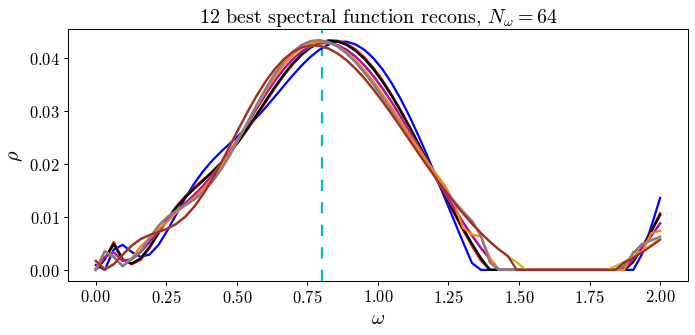

In [24]:
color_table = ['b', 'r', 'g', 'k', 'c', 'y', 'm', 'tab:orange', 'tab:pink', 'tab:gray', 'tab:olive', 'brown']
colors = color_table[:n_best]
with sns.plotting_context('talk'):
    fig, ax = plt.subplots(1, figsize = (10, 5))
    pt.add_line(ax, omega0, color = 'c', dashes = (5, 5), label = '$\\omega_0$')
    for ii in range(n_best):
        pt.plot_1d_function(omegas, best_rho[ii], ax = ax, col = [colors[ii]], title = str(n_best) + \
                         ' best spectral function recons, $N_\omega = $' + str(Nomega), \
                         ax_label = ['$\\omega$', '$\\rho$'], legend = False)
#     plt.tight_layout()
#     plt.savefig('/Users/theoares/Dropbox (MIT)/research/spectral/sparse_modeling/tests/test1/param_scan_' \
#                         + str(Nomega) + '.pdf')

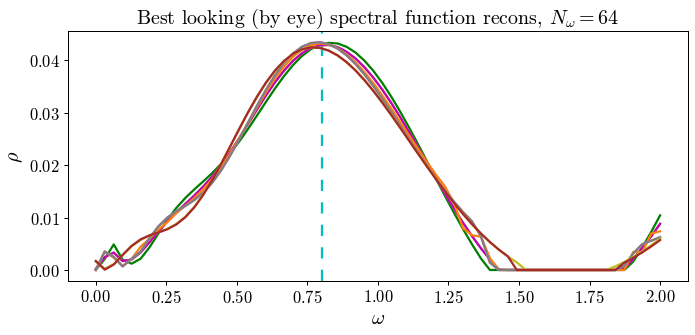

In [25]:
# at the moment, I just want to look at a subset of these because they pass the eye test. However, should add a term 
# in the fidelity function so that these are the ones which are picked out. 
best_recons = [2, 5, 6, 7, 8, 9, 10, 11]    # just look at a subset of them
subcolors = [color_table[ii] for ii in best_recons]
with sns.plotting_context('talk'):
    fig, ax = plt.subplots(1, figsize = (10, 5))
    pt.add_line(ax, omega0, color = 'c', dashes = (5, 5), label = '$\\omega_0$')
    for i, ii in enumerate(best_recons):
        pt.plot_1d_function(omegas, best_rho[ii], ax = ax, col = subcolors[i], title = \
                         'Best looking (by eye) spectral function recons, $N_\omega = $' + str(Nomega), \
                         ax_label = ['$\\omega$', '$\\rho$'], legend = False)
#     plt.tight_layout()
#     plt.savefig('/Users/theoares/Dropbox (MIT)/research/spectral/sparse_modeling/tests/test1/param_scan_' \
#                         + str(Nomega) + '_best.pdf')

In [22]:
# play with the recons-- why are their primal residuals all so close together?